In [35]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import yfinance as yf
from math import sqrt
import scipy.stats as ss
import scipy.optimize as opt
from datetime import datetime
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from pandas_datareader import DataReader
from sklearn.metrics import mean_squared_error

In [36]:
start_date = datetime(2020,1,1)
end_date = datetime(2023,4,28)

TSLA = yf.download('TSLA', start_date, end_date)
TSLA.reset_index(inplace = True)

RACE = yf.download('RACE', start_date, end_date)
RACE.reset_index(inplace = True)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [37]:
TSLA.describe()

,Open,High,Low,Close,Adj Close,Volume
count,836.000000,836.000000,836.000000,836.000000,836.000000,8.360000e+02
mean,203.525671,208.302934,198.256259,203.380179,203.380179,1.350532e+08
std,92.247467,94.146319,89.989651,92.025282,92.025282,9.649381e+07
min,24.980000,26.990667,23.367332,24.081333,24.081333,2.940180e+07
25%,140.337502,143.450001,136.626671,140.297497,140.297497,7.169858e+07
50%,216.298332,221.651665,209.481667,216.459999,216.459999,9.997470e+07
75%,270.967491,275.659172,262.853333,268.468323,268.468323,1.712361e+08
max,411.470001,414.496674,405.666656,409.970001,409.970001,9.140820e+08


In [38]:
RACE.describe()

,Open,High,Low,Close,Adj Close,Volume
count,836.000000,836.000000,836.000000,836.000000,836.000000,8.360000e+02
mean,206.936567,208.836867,205.055768,206.921363,204.076641,3.523464e+05
std,30.804355,30.740278,30.819841,30.829888,31.059807,2.189008e+05
min,129.360001,134.910004,127.730003,129.320007,125.947647,5.380000e+04
25%,187.400002,189.747498,185.134998,187.600002,185.118633,2.115500e+05
50%,206.995003,209.049995,205.299995,207.334999,204.184616,2.959000e+05
75%,221.002499,222.730000,218.962498,220.577499,217.648903,4.313000e+05
max,284.940002,286.609985,284.350006,285.529999,283.487335,1.991000e+06


In [39]:
TSLA['Typical_Price'] = TSLA[['High', 'Low', 'Close']].mean(axis = 1)
TSLA['lRETS'] = (np.log(TSLA.Close) - np.log(TSLA.Close.shift(1))) * 100.
TSLA.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Typical_Price,lRETS
0,2020-01-02,28.299999,28.713333,28.114000,28.684000,28.684000,142981500,28.503778,NaN
1,2020-01-03,29.366667,30.266666,29.128000,29.534000,29.534000,266677500,29.642889,2.920268
2,2020-01-06,29.364668,30.104000,29.333332,30.102667,30.102667,151995000,29.846666,1.907161
3,2020-01-07,30.760000,31.441999,30.224001,31.270666,31.270666,268231500,30.978889,3.806671
4,2020-01-08,31.580000,33.232666,31.215334,32.809334,32.809334,467164500,32.419111,4.803257


In [40]:
RACE['Typical_Price'] = RACE[['High', 'Low', 'Close']].mean(axis = 1)
RACE['lRETS'] = (np.log(RACE.Close) - np.log(RACE.Close.shift(1))) * 100.
RACE.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Typical_Price,lRETS
0,2020-01-02,167.050003,168.774002,166.630005,168.509995,164.115662,195800,167.971334,NaN
1,2020-01-03,166.759995,167.750000,166.268005,166.729996,162.382065,134600,166.916000,-1.061935
2,2020-01-06,164.759995,166.289993,164.759995,165.850006,161.525040,169900,165.633331,-0.529191
3,2020-01-07,165.979996,166.119995,165.179993,165.220001,160.911469,309300,165.506663,-0.380588
4,2020-01-08,167.039993,168.970001,166.750000,168.539993,164.144867,261400,168.086665,1.989514


/Users/meetdoshi/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/meetdoshi/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


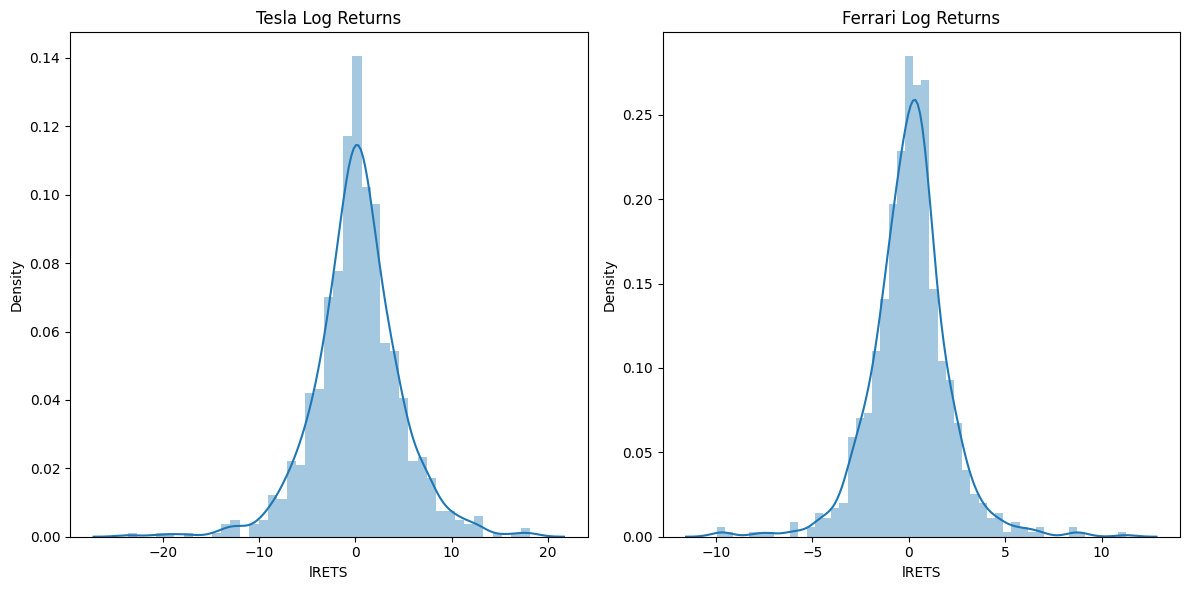

In [41]:
fig, axes = plt.subplots(1, 2, figsize = (12, 6))

sns.distplot(TSLA['lRETS'].dropna(), ax = axes[0])
axes[0].set_title('Tesla Log Returns')

sns.distplot(RACE['lRETS'].dropna(), ax = axes[1])
axes[1].set_title('Ferrari Log Returns')
plt.tight_layout()
plt.show()

Defining the GARCH Model and Likelihood Function:

In [42]:
def GARCH(Y):
    "Initialize Params:"
    mu = param0[0]
    omega = param0[1]
    alpha = param0[2]
    beta = param0[3]
    T = Y.shape[0]
    GARCH_Dens = np.zeros(T)
    sigma2 = np.zeros(T)
    F = np.zeros(T)
    v = np.zeros(T)
    for t in range(1,T):
        sigma2[t] = omega + alpha*((Y[t-1]-mu)**2)+beta*(sigma2[t-1]);
        F[t] = Y[t] - mu-np.sqrt(sigma2[t])*np.random.normal(0,1,1)
        v[t] = sigma2[t]
        GARCH_Dens[t] = (1/2)*np.log(2*np.pi)+(1/2)*np.log(v[t])+(1/2)*(F[t]/v[t])
        Likelihood = np.sum(GARCH_Dens[1:-1])
    return Likelihood

In [43]:
def GARCH_Prod(params, Y0, T):
    mu = params[0]
    omega = params[1]
    alpha = params[2]
    beta = params[3]
    Y = np.zeros(T)
    sigma2 = np.zeros(T)
    Y[0] = Y0
    sigma2[0] = 0.0001
    for t in range(1,T):
        sigma2[t] = omega + alpha*((Y[t-1]-mu)**2)+beta*(sigma2[t-1]);
        Y[t] = mu+np.sqrt(sigma2[t])*np.random.normal(0,1,1)
    return Y

         Current function value: 0.440207
         Iterations: 4
         Function evaluations: 161
         Gradient evaluations: 29


/var/folders/p6/09_jyd9922d_qcbtp4sgzp3h0000gn/T/ipykernel_74470/328700814.py:5: OptimizeWarning: Unknown solver options: xtol
  param_star = opt.minimize(GARCH, param0, method ='BFGS' , options = {'xtol' : 1e-8, 'disp' : True})


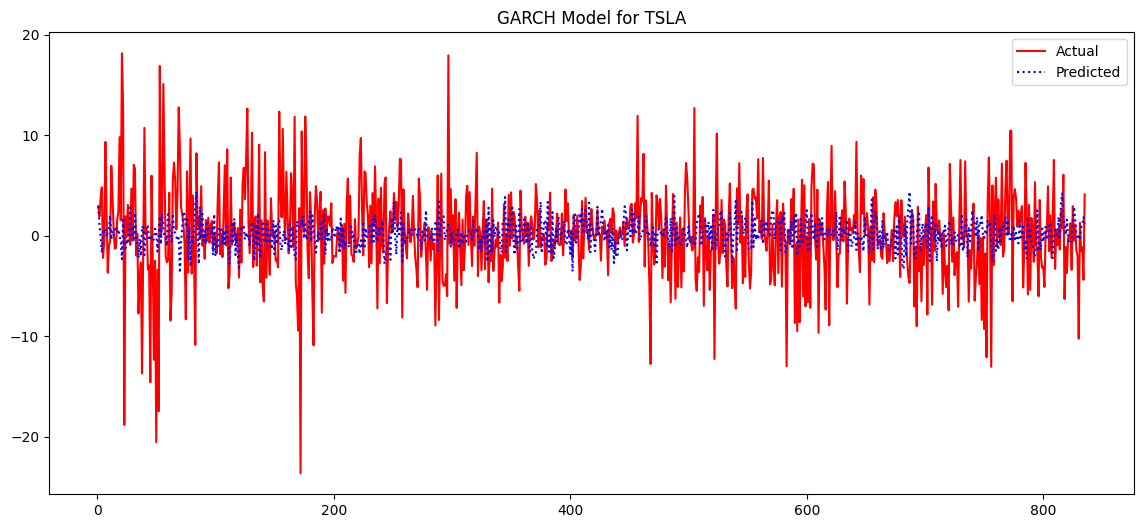

In [44]:
Y = TSLA['lRETS'].dropna()
T = len(Y)

param0 = np.array([0.1, 0.6, 0.15, 0.5])
param_star = opt.minimize(GARCH, param0, method ='BFGS' , options = {'xtol' : 1e-8, 'disp' : True})

Y_GARCH = GARCH_Prod(param_star.x, Y[1], T)
timevec = np.linspace(1, T, T)

fig = plt.figure(figsize = (14, 6))
plt.plot(timevec, Y, 'r-', label = 'Actual')
plt.plot(timevec, Y_GARCH, 'b:', label = 'Predicted')

plt.legend(loc = 'upper right')
plt.title("GARCH Model for TSLA")
plt.show()

In [45]:
GARCH_TSLA = pd.DataFrame({'Actual':list(Y), 'Predicted':list(Y_GARCH)})
GARCH_TSLA

,Actual,Predicted
0,2.920268,2.920268
1,1.907161,1.063824
2,3.806671,-0.149707
3,4.803257,-1.710905
4,-2.218939,0.461779
...,...,...
830,1.274133,-0.445005
831,-1.544455,0.798580
832,-1.163310,1.044977
833,-4.402465,1.823833


In [46]:
RMS_TSLA = sqrt(mean_squared_error(GARCH_TSLA['Actual'], GARCH_TSLA['Predicted']))
RMS_TSLA

4.729825146452559

/var/folders/p6/09_jyd9922d_qcbtp4sgzp3h0000gn/T/ipykernel_74470/4211405203.py:5: OptimizeWarning: Unknown solver options: xtol
  param_star = opt.minimize(GARCH, param0, method = 'BFGS' , options = {'xtol' : 1e-8, 'disp' : True})


         Current function value: -0.686606
         Iterations: 1
         Function evaluations: 108
         Gradient evaluations: 20


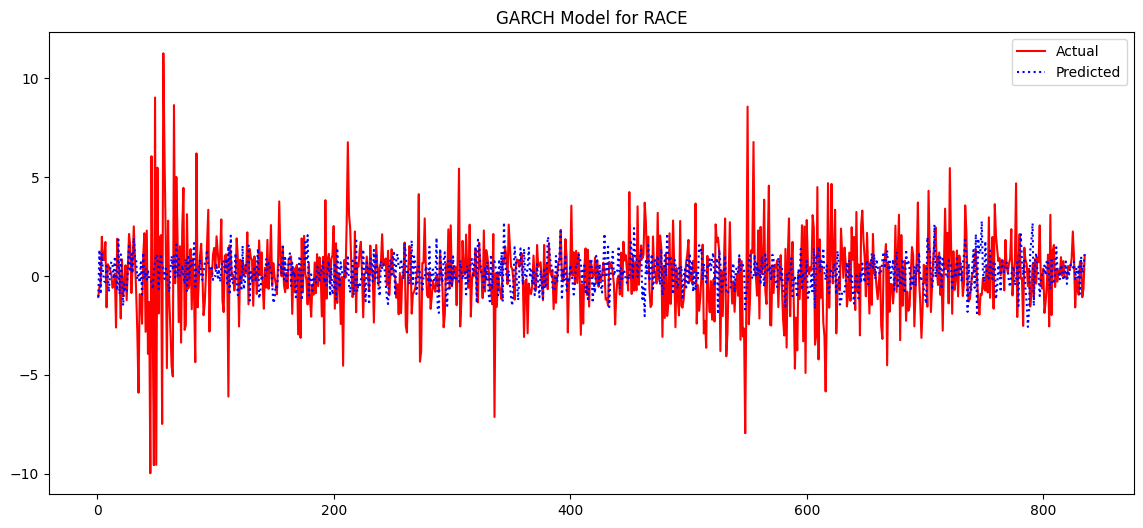

In [47]:
Y = RACE['lRETS'].dropna()
T = len(Y)

param0 = np.array([0.18, 0.27, 0.15, 0.4])
param_star = opt.minimize(GARCH, param0, method = 'BFGS' , options = {'xtol' : 1e-8, 'disp' : True})
Y_GARCH = GARCH_Prod(param_star.x,Y[1],T)
timevec = np.linspace(1,T,T)

fig = plt.figure(figsize = (14,6))
plt.plot(timevec, Y, 'r-', label = 'Actual')
plt.plot(timevec, Y_GARCH, 'b:', label = 'Predicted')

plt.legend(loc = 'upper right')
plt.title("GARCH Model for RACE")
plt.show()

In [48]:
GARCH_RACE = pd.DataFrame({'Actual':list(Y), 'Predicted':list(Y_GARCH)})
GARCH_RACE

,Actual,Predicted
0,-1.061935,-1.061935
1,-0.529191,1.323558
2,-0.380588,-0.915353
3,1.989514,1.153146
4,0.809584,0.129653
...,...,...
830,0.732815,-0.899111
831,0.773894,0.980477
832,-1.069264,0.161025
833,-0.651440,0.371268


In [49]:
RMS_RACE = sqrt(mean_squared_error(GARCH_RACE['Actual'], GARCH_RACE['Predicted']))
RMS_RACE

2.203856388739265

In [50]:
y_pred = [] * 1000

for i in range(len(GARCH_TSLA)+1):
    if i == 0:
        y_pred.append(math.exp(GARCH_TSLA['Predicted'][i]/100) * TSLA['Close'][i])
    else:
        y_pred.append(math.exp(GARCH_TSLA['Predicted'][i-1]/100) * TSLA['Close'][i-1])

In [51]:
TSLA_Pred = pd.DataFrame({'Actual_Close_Price': TSLA['Close'], 'Predicted_Close_Price': list(y_pred), 'Date': TSLA.index})
TSLA_Pred.set_index('Date', inplace = True)

In [52]:
TSLA_Pred

,Actual_Close_Price,Predicted_Close_Price
Date,,
0,28.684000,29.534000
1,29.534000,29.534000
2,30.102667,29.849867
3,31.270666,30.057635
4,32.809334,30.740206
...,...,...
831,165.080002,162.266304
832,162.550003,166.403575
833,160.669998,164.257518


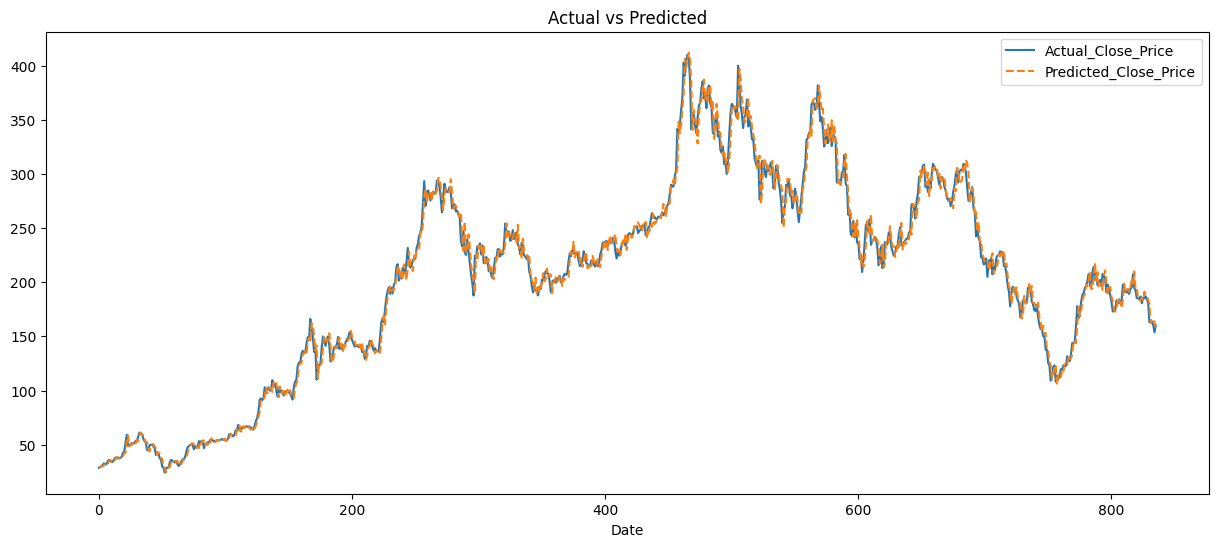

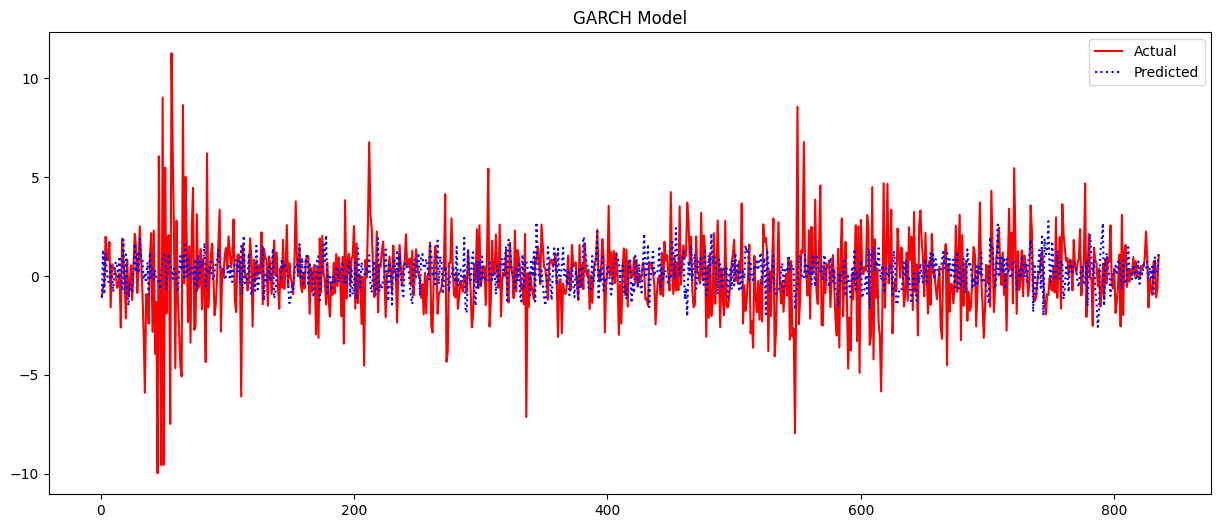

In [53]:
TSLA_Pred[['Actual_Close_Price', 'Predicted_Close_Price']].loc[:].plot(figsize = (15, 6), style = ['-', '--'], title = 'Actual vs Predicted')
fig = plt.figure(figsize = (15, 6))
plt.plot(timevec, Y, 'r-', label = 'Actual')
plt.plot(timevec, Y_GARCH, 'b:', label = 'Predicted')
plt.legend(loc = 'upper right')
plt.title("GARCH Model")
plt.show()

Trading Strategy



In [54]:
signal = 0
amount = 10000
Amount = []
balance = 0
action = []
portfolio = 0
Portfolio = []
stocks = 0
Stocks = []


for i in range(len(TSLA_Pred)-1):
    if TSLA_Pred['Predicted_Close_Price'][i+1] > TSLA_Pred['Actual_Close_Price'][i]:
        if signal == 0:
            action.append('Buy')
            stocks = int(amount / TSLA_Pred['Actual_Close_Price'][i])
            balance = int(amount % TSLA_Pred['Actual_Close_Price'][i])
            portfolio = stocks * TSLA_Pred['Actual_Close_Price'][i]
            signal = 1
            amount = portfolio + balance
            print('Stock:', TSLA_Pred['Actual_Close_Price'][i] , 'Action:', action[i], 'Portfolio:', round(portfolio,2), 'Stocks:', stocks, 'Balance_init:', balance, 'Total($)', round(amount,2))
            Portfolio.append(round(portfolio, 5))
            Amount.append(round(amount, 0))
            Stocks.append(stocks)
        else:
            action.append('Bought--Holding')
            portfolio = stocks * TSLA_Pred['Actual_Close_Price'][i]
            amount = portfolio + balance
            print('Stock:', TSLA_Pred['Actual_Close_Price'][i], 'Action:',action[i], 'Portfolio:', round(portfolio,2), 'Stocks:', stocks, 'Balance_init:', balance, 'Total($)', round(amount,2))
            Portfolio.append(round(portfolio, 5))
            Amount.append(round(amount, 0))
            Stocks.append(stocks)

    elif TSLA_Pred['Predicted_Close_Price'][i+1] < TSLA_Pred['Actual_Close_Price'][i]:
        if signal == 1:
            action.append('Sell')
            portfolio = stocks * TSLA_Pred['Actual_Close_Price'][i]
            signal = 0
            stocks = 0
            amount = balance + portfolio
            portfolio = 0
            balance = 0
            print('Stock:', TSLA_Pred['Actual_Close_Price'][i], 'Action:', action[i], 'Portfolio:', round(portfolio,2), 'Stocks:', stocks, 'Balance_init:', balance, 'Total($)', round(amount,2))
            Portfolio.append(round(portfolio, 5))
            Amount.append(round(amount, 0))
            Stocks.append(stocks)
        else:
            action.append('Price-Prediction-Already-Lower')
            print('Stock:',TSLA_Pred['Actual_Close_Price'][i], 'Action:', action[i], 'Portfolio:', round(portfolio,2), 'Stocks:', stocks, 'Balance_init:', balance, 'Total($)', round(amount,2))
            Portfolio.append(round(portfolio, 5))
            Amount.append(round(amount, 0))
            Stocks.append(stocks)

    print('\n')

Stock: 28.68400001525879 Action: Buy Portfolio: 9982.03 Stocks: 348 Balance_init: 17 Total($) 9999.03


Stock: 29.534000396728516 Action: Bought--Holding Portfolio: 10277.83 Stocks: 348 Balance_init: 17 Total($) 10294.83


Stock: 30.1026668548584 Action: Sell Portfolio: 0 Stocks: 0 Balance_init: 0 Total($) 10492.73


Stock: 31.270666122436523 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 Total($) 10492.73


Stock: 32.80933380126953 Action: Buy Portfolio: 10466.18 Stocks: 319 Balance_init: 26 Total($) 10492.18


Stock: 32.089332580566406 Action: Bought--Holding Portfolio: 10236.5 Stocks: 319 Balance_init: 26 Total($) 10262.5


Stock: 31.876667022705078 Action: Bought--Holding Portfolio: 10168.66 Stocks: 319 Balance_init: 26 Total($) 10194.66


Stock: 34.990665435791016 Action: Sell Portfolio: 0 Stocks: 0 Balance_init: 0 Total($) 11188.02


Stock: 35.861331939697266 Action: Buy Portfolio: 11152.87 Stocks: 311 Balance_init: 35 Total($) 11187.87


Stock: 34.

In [55]:
Strategy_Result = pd.DataFrame({'Actual_Close_Price': TSLA['Close'][1:],
                               'Predicted_Close_Price': list(y_pred[1:]),
                               'Date': TSLA.index[1:],
                               'Action': action,
                               'Amount($)':Amount,
                               'Portfolio($)': Portfolio,
                               'Stocks': Stocks})

Strategy_Result.head()

,Actual_Close_Price,Predicted_Close_Price,Date,Action,Amount($),Portfolio($),Stocks
1,29.534000,29.534000,1,Buy,9999.0,9982.03201,348
2,30.102667,29.849867,2,Bought--Holding,10295.0,10277.83214,348
3,31.270666,30.057635,3,Sell,10493.0,0.00000,0
4,32.809334,30.740206,4,Price-Prediction-Already-Lower,10493.0,0.00000,0
5,32.089333,32.961191,5,Buy,10492.0,10466.17748,319


<Axes: title={'center': 'Total Amount'}>

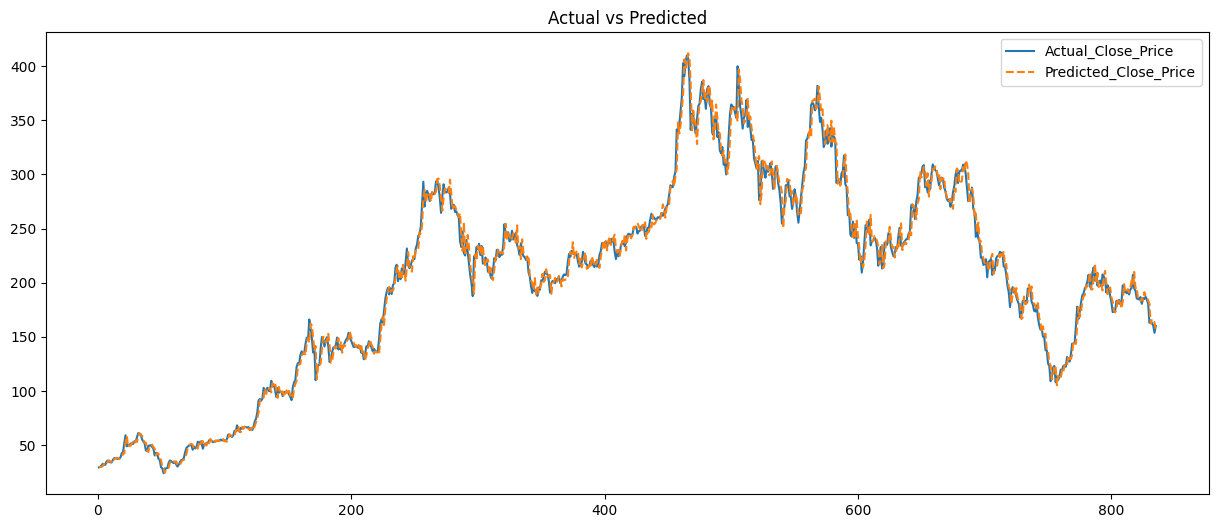

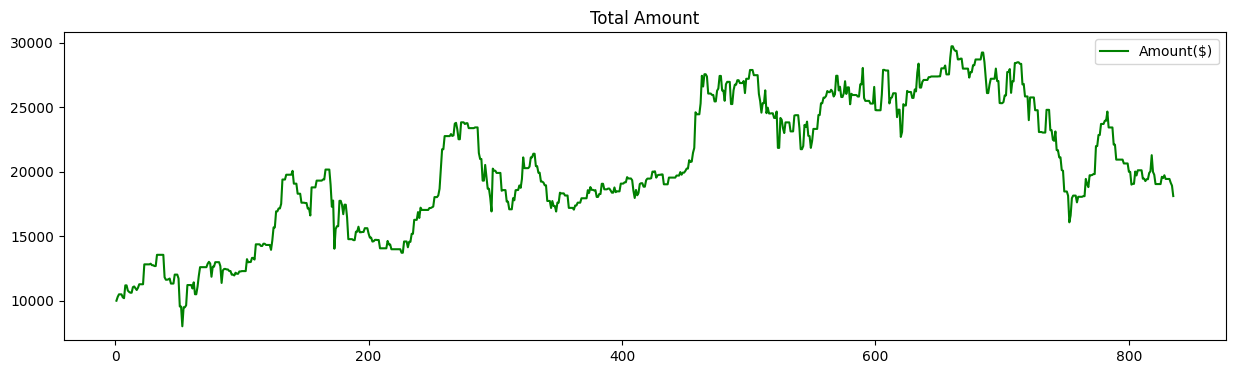

In [56]:
Strategy_Result[['Actual_Close_Price', 'Predicted_Close_Price']].loc[:].plot(figsize = (15, 6), style = ['-', '--'], title = 'Actual vs Predicted')
Strategy_Result[['Amount($)']].iloc[0:].plot(figsize = (15, 4), style = ['-g'], title = 'Total Amount')

In [57]:
Profit = (Amount[-1] / 10000) - 1  # Assuming Amount[-1] represents the final amount
Profit_percent = Profit * 100

print('Initial Investment: $10,000')
print('Final Amount:', Amount[-1], '$')
print('Profit Percentage:', Profit_percent, '%')

Initial Investment: $10,000
Final Amount: 18106.0 $
Profit Percentage: 81.06 %
